- Data: clean dataset where missing data was replaced with 'missing'. No imputing.
- Approach: 
    - exclude text features.
    - desc. features: brand, shipping, category, sub_cat1
    - basic approach: ordinal encoding for brand and categories
    - 2nd approach: encode brand and categories using OHE
- Models:
    - Random Forest
    - Lasso Regressor
    - Ridge Regressor
    - LightGBM
    - SVM
    - Linear Regression
    - SGD
- Evaluation metrics:
    - RMSLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import swifter

from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, OrdinalEncoder, StandardScaler
from scipy.sparse import hstack
from IPython.display import Markdown

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

#### Utils

In [3]:
def get_pred_price(log_price):
    return np.exp(log_price)-1

def normalize_text(text):
    '''
    Handles diacritic marks, superscripts and subscripts.
    Returns the text in lowercase.
    '''
    text = text.replace('–', '-').strip()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8").lower()
    return text

def pre_process_brand(text):
    clean_text = normalize_text(text).replace(' ', '_')
    #clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    return clean_text

def pre_process_category(text):
    clean_text = normalize_text(text)
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text).replace(' ', '_')
    return clean_text

def pred_vs_actual(pred, actual):
    fig, ax = plt.subplots(figsize=(10,6), gridspec_kw={'hspace': 0.3})
    x = range(len(actual))

    ax.plot(x, actual, label='Actual values')
    ax.plot(x, pred, label='Predicted values')
    ax.legend(loc=1, bbox_to_anchor=(0.75, 0, 0.5, 1))
    plt.show()

___

In [4]:
data_path = 'data/'
data_file_name = 'mercari_eda_cleaned.csv'
data_full_path = data_path + data_file_name

product_listings_mercari = pd.read_csv(data_full_path, keep_default_na=False)
display(product_listings_mercari.shape)
product_listings_mercari.head()

(1481661, 12)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity


In [5]:
product_listings_mercari['brand_name'] = product_listings_mercari['brand_name'].apply(pre_process_brand)
product_listings_mercari['main_cat'] = product_listings_mercari['main_cat'].apply(pre_process_category)
product_listings_mercari['sub_cat1'] = product_listings_mercari['sub_cat1'].apply(pre_process_category)
product_listings_mercari['sub_cat2'] = product_listings_mercari['sub_cat2'].apply(pre_process_category)

product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t_shirts,mlb cincinnati reds shirt size xl,description yet
1,1,Razer BlackWidow Chroma Keyboard,3,razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers_tablets,components_parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...
2,2,AVA-VIV Blouse,1,target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops_blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home_decor,home_decor_accents,leather horse statues,new tags leather horses retail stand foot high...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity


#### RMSLE
"The Robustness of RMSLE to the outliers, the property of calculating the relative error between the Predicted and Actual Values, the most unique property of the RMLSE that it penalizes the underestimation of the actual value more severely than it does for the Overestimation."
- https://www.kaggle.com/competitions/ashrae-energy-prediction/discussion/113064
- https://www.datascienceland.com/blog/difference-between-rmse-and-rmsle-656/

<div>
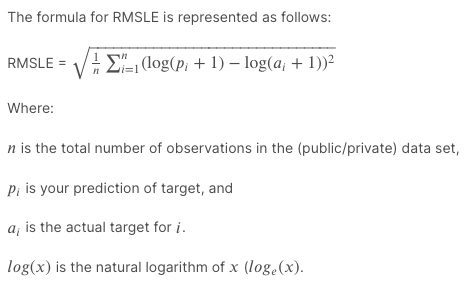
</div>

In [6]:
# preparing target for RMSLE
product_listings_mercari['log_price'] = np.log1p(product_listings_mercari['price'].values.astype(np.float32))
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,log_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t_shirts,mlb cincinnati reds shirt size xl,description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers_tablets,components_parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...,3.970292
2,2,AVA-VIV Blouse,1,target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops_blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...,2.397895
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home_decor,home_decor_accents,leather horse statues,new tags leather horses retail stand foot high...,3.583519
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity,3.806663


#### Splitting data

In [7]:
features = ['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']
X, y = product_listings_mercari[features], product_listings_mercari['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1185328, 6), (296333, 6))

Data Considerations:
- continuous target ! error based models
- categorical target ! information and probability models
- continuous descriptive features ! (+cat. target) similarity
- based models / (+cont. target) error based models
- categorical descriptive features ! information and
- probability models
- lots of descriptive features (curse of dimensionality) !
- feature selection

___
### Basic Approach

In [8]:
X_train.head()

,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2
1142652,2,missing,0,electronics,tv_audio_surveillance,headphones
1142448,2,lularoe,0,women,athletic_apparel,pants_tights_leggings
220982,2,missing,1,vintage_collectibles,antique,book
479456,1,missing,1,vintage_collectibles,collectibles,souvenir
1299063,3,victoria's_secret,0,women,underwear,bras


In [9]:
# ordinal encoder for brand_name

oe_brand = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_brand.fit(product_listings_mercari.brand_name.values.reshape(-1,1))

tr_brand_vec = oe_brand.transform(X_train.brand_name.values.reshape(-1,1))
val_brand_vec = oe_brand.transform(X_test.brand_name.values.reshape(-1,1))

tr_brand_vec.shape, val_brand_vec.shape

((1185328, 1), (296333, 1))

In [10]:
# ordinal encoder for category-related features

# main cat
oe_mcat = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_mcat.fit(product_listings_mercari.main_cat.values.reshape(-1,1))

tr_mcat_vec = oe_mcat.transform(X_train.main_cat.values.reshape(-1,1))
val_mcat_vec = oe_mcat.transform(X_test.main_cat.values.reshape(-1,1))

# sub cat1
oe_scat1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_scat1.fit(product_listings_mercari.sub_cat1.values.reshape(-1,1))

tr_scat1_vec = oe_scat1.transform(X_train.sub_cat1.values.reshape(-1,1))
val_scat1_vec = oe_scat1.transform(X_test.sub_cat1.values.reshape(-1,1))

# sub cat2
oe_scat2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_scat2.fit(product_listings_mercari.sub_cat2.values.reshape(-1,1))

tr_scat2_vec = oe_scat2.transform(X_train.sub_cat2.values.reshape(-1,1))
val_scat2_vec = oe_scat2.transform(X_test.sub_cat2.values.reshape(-1,1))

tr_mcat_vec.shape, val_mcat_vec.shape, tr_scat1_vec.shape, val_scat1_vec.shape, tr_scat2_vec.shape, val_scat2_vec.shape

((1185328, 1),
 (296333, 1),
 (1185328, 1),
 (296333, 1),
 (1185328, 1),
 (296333, 1))

<u>Stacking all features</u>

In [11]:
x_train = np.hstack((X_train.item_condition_id.values.reshape(-1,1), tr_brand_vec, X_train.shipping.values.reshape(-1,1), tr_mcat_vec, tr_scat1_vec, tr_scat2_vec))
x_train.shape

(1185328, 6)

In [12]:
x_val = np.hstack((X_test.item_condition_id.values.reshape(-1,1), val_brand_vec, X_test.shipping.values.reshape(-1,1), val_mcat_vec, val_scat1_vec, val_scat2_vec))
x_val.shape

(296333, 6)

#### Ridge

Resources:
- https://www.kaggle.com/code/deepakdodi/lasso-and-ridge-hypertuning-over-gapminder-dataset/notebook
- https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
- https://medium.com/all-about-ml/lasso-and-ridge-regularization-a0df473386d5

In [14]:
'''Hyper-param tuning'''

ridge = Ridge()
ridge_params = {'alpha': list(np.logspace(-4, 0, 30))} # from 0.0001 to 1

grid_cv = GridSearchCV(ridge, param_grid=ridge_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

CPU times: user 433 ms, sys: 513 ms, total: 946 ms
Wall time: 9.89 s


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.00013738237958832623,
                                   0.00018873918221350977,
                                   0.0002592943797404667, 0.0003562247890262444,
                                   0.0004893900918477494, 0.0006723357536499335,
                                   0.0009236708571873865, 0.0012689610031679222,
                                   0.0017433288221999873, 0.002395026619987486,
                                   0.0032903445623126675, 0.004520353656360241,
                                   0.006210169418915...172805,
                                   0.011721022975334805, 0.01610262027560939,
                                   0.02212216291070448, 0.03039195382313198,
                                   0.041753189365604, 0.05736152510448681,
                                   0.07880462815669913, 0.1082636733874054,
                                   0.14873521072935117, 0.20433597178569418,
                                   0.2807216203941176, 0.38566204211634725,
                                   0.5298316906283708, 0.7278953843983146,
                                   1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [15]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.720436 using {'alpha': 1.0}


In [16]:
# top 5 combination of params
df = pd.DataFrame(grid_cv.cv_results_)
df = df.sort_values('rank_test_score')[['param_alpha', 'params', 'mean_test_score','std_test_score','rank_test_score']]
df.iloc[:5,]

,param_alpha,params,mean_test_score,std_test_score,rank_test_score
29,1.0,{'alpha': 1.0},-0.720436,0.002009,1
28,0.727895,{'alpha': 0.7278953843983146},-0.720436,0.002009,2
27,0.529832,{'alpha': 0.5298316906283708},-0.720436,0.002009,3
26,0.385662,{'alpha': 0.38566204211634725},-0.720436,0.002009,4
25,0.280722,{'alpha': 0.2807216203941176},-0.720436,0.002009,5


Training the model using the best params

RMSLE - Root Mean Squared Log Error .
This metric is used when the Target variable is converted into Log(Target).
so instead of looking at RMSLE, you can look for RMSE (generally we use this). You can convert the predictions to ypred = exp(predictions)
and then np.sqrt(mean_squared_error(y_test, ypred)) will give the final RMSE.

#### Execution Time - Training

CPU times: user 48 ms, sys: 3.64 ms, total: 51.6 ms
Wall time: 43.7 ms


#### Execution Time - Prediction

CPU times: user 6.78 ms, sys: 7.33 ms, total: 14.1 ms
Wall time: 2.88 ms


#### Model in Test Data

R2: 0.0674
RMSLE: 0.7199


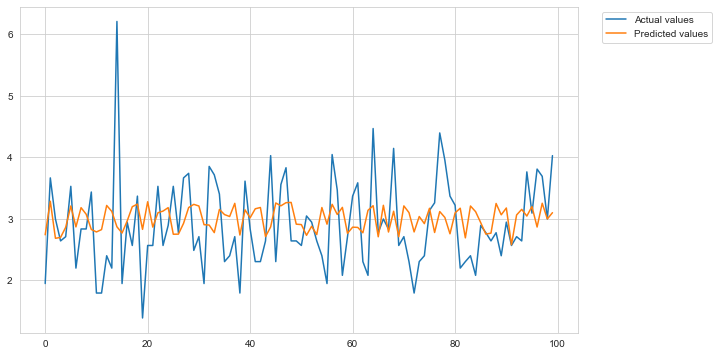

In [17]:
ridge_best = Ridge(alpha=1)
display(Markdown("#### Execution Time - Training"))
%time ridge_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = ridge_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### Lasso

Resources:
- https://www.mygreatlearning.com/blog/understanding-of-lasso-regression
- https://www.statisticshowto.com/lasso-regression/
- https://machinelearningmastery.com/lasso-regression-with-python/
- https://www.kaggle.com/code/deepakdodi/lasso-and-ridge-hypertuning-over-gapminder-dataset/notebook

In [18]:
'''Hyper-param tuning'''

lasso = Lasso()
lasso_params = {'alpha': list(np.logspace(-4, 0, 30))} # from 0.0001 to 1

grid_cv = GridSearchCV(lasso, param_grid=lasso_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

CPU times: user 552 ms, sys: 410 ms, total: 962 ms
Wall time: 9.49 s


GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.00013738237958832623,
                                   0.00018873918221350977,
                                   0.0002592943797404667, 0.0003562247890262444,
                                   0.0004893900918477494, 0.0006723357536499335,
                                   0.0009236708571873865, 0.0012689610031679222,
                                   0.0017433288221999873, 0.002395026619987486,
                                   0.0032903445623126675, 0.004520353656360241,
                                   0.006210169418915...172805,
                                   0.011721022975334805, 0.01610262027560939,
                                   0.02212216291070448, 0.03039195382313198,
                                   0.041753189365604, 0.05736152510448681,
                                   0.07880462815669913, 0.1082636733874054,
                                   0.14873521072935117, 0.20433597178569418,
                                   0.2807216203941176, 0.38566204211634725,
                                   0.5298316906283708, 0.7278953843983146,
                                   1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [19]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.720436 using {'alpha': 0.0001}


In [20]:
# top 5 combination of params
df = pd.DataFrame(grid_cv.cv_results_)
df = df.sort_values('rank_test_score')[['param_alpha', 'params', 'mean_test_score','std_test_score','rank_test_score']]
df.iloc[:5,]

,param_alpha,params,mean_test_score,std_test_score,rank_test_score
0,0.0001,{'alpha': 0.0001},-0.720436,0.002009,1
1,0.000137,{'alpha': 0.00013738237958832623},-0.720436,0.002009,2
2,0.000189,{'alpha': 0.00018873918221350977},-0.720436,0.002009,3
3,0.000259,{'alpha': 0.0002592943797404667},-0.720437,0.002008,4
4,0.000356,{'alpha': 0.0003562247890262444},-0.720437,0.002008,5


#### Execution Time - Training

CPU times: user 184 ms, sys: 31.4 ms, total: 215 ms
Wall time: 69.9 ms


#### Execution Time - Prediction

CPU times: user 3.49 ms, sys: 1.44 ms, total: 4.93 ms
Wall time: 1.39 ms


#### Model in Test Data

R2: 0.0674
RMSLE: 0.7199


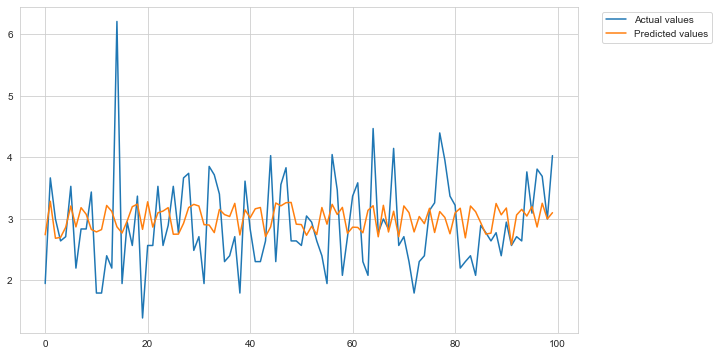

In [21]:
lasso_best = Lasso(alpha=0.0001)
display(Markdown("#### Execution Time - Training"))
%time lasso_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lasso_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### LightGBM

Resources:
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
- https://neptune.ai/blog/lightgbm-parameters-guide
- https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization#:~:text=The%20differences%20between%20L1%20and,regularization%20solution%20is%20non%2Dsparse.

In [22]:
'''Hyper-param tuning'''

lgb = LGBMRegressor(random_state=42)
lgb_params = { "learning_rate": [0.1,0.03,0.3], 
              "max_depth": [3, 5, 7], 
              "n_estimators": [80, 100, 150, 200],
              "reg_alpha": [0, 1, 1.5]
}

grid_cv = GridSearchCV(lgb, param_grid=lgb_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

CPU times: user 19 s, sys: 5.07 s, total: 24.1 s
Wall time: 12min 31s


GridSearchCV(estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.03, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [80, 100, 150, 200],
                         'reg_alpha': [0, 1, 1.5]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [23]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.560031 using {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1.5}


In [24]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

,params,mean_test_score,std_test_score,rank_test_score
107,"{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1.5}",-0.560031,0.001271,1
105,"{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0}",-0.560063,0.001362,2
106,"{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1}",-0.560104,0.001283,3
104,"{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 1.5}",-0.563099,0.001276,4
103,"{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 1}",-0.563278,0.001419,5


#### Execution Time - Training

CPU times: user 16.6 s, sys: 2.86 s, total: 19.5 s
Wall time: 3.44 s


#### Execution Time - Classification

CPU times: user 3.18 s, sys: 38 ms, total: 3.22 s
Wall time: 429 ms


#### Model in Test Data

R2: 0.4383
RMSLE: 0.5587


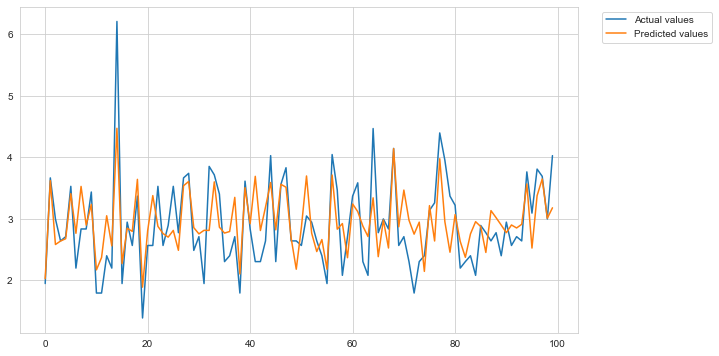

In [121]:
lgb_best = LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=7, n_estimators=200, reg_alpha=1.5)

display(Markdown("#### Execution Time - Training"))
%time lgb_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lgb_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### SVR
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
- http://adrem.uantwerpen.be/bibrem/pubs/IJCNN2007.pdf

In [32]:
from sklearn.svm import LinearSVR

# scaling the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

'''Hyper-param tuning'''

svr = LinearSVR(max_iter=2000)
svr_params = {'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}

grid_cv = GridSearchCV(svr, param_grid=svr_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True, cv=3)
%time grid_cv.fit(x_train_scaled, y_train)

CPU times: user 40.2 s, sys: 346 ms, total: 40.6 s
Wall time: 1min 14s


GridSearchCV(cv=3, estimator=LinearSVR(max_iter=2000), n_jobs=-1,
             param_grid={'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [33]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.720440 using {'loss': 'squared_epsilon_insensitive'}


In [34]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

,params,mean_test_score,std_test_score,rank_test_score
1,{'loss': 'squared_epsilon_insensitive'},-0.720440,0.001136,1
0,{'loss': 'epsilon_insensitive'},-0.727289,0.000850,2


#### Execution Time - Training

CPU times: user 3min 4s, sys: 689 ms, total: 3min 5s
Wall time: 3min 5s


#### Execution Time - Prediction

CPU times: user 15.7 ms, sys: 4.12 ms, total: 19.8 ms
Wall time: 5.05 ms


#### Model in Test Data

R2: -4.2301
RMSLE: 1.7048


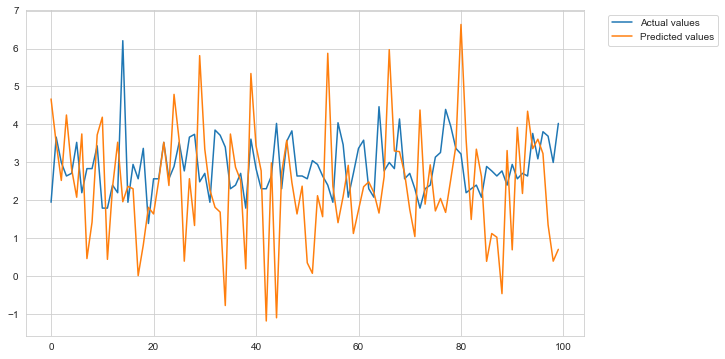

In [35]:
svr_best = LinearSVR(loss='squared_epsilon_insensitive')

display(Markdown("#### Execution Time - Training"))
%time svr_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = svr_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### SGD
- https://scikit-learn.org/stable/modules/sgd.html#regression
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

In [36]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

'''Hyper-param tuning'''

sgd = SGDRegressor()
sgd_params = grid_param = {'alpha': 10.0 ** -np.arange(1, 7),
                           'penalty': ['l2', 'l1', 'elasticnet'], 
                           'learning_rate': ['constant', 'optimal', 'invscaling'], 
                           'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                           'epsilon': [0.001, 0.01, 0.1, 0, 1, 10]
}

grid_cv = GridSearchCV(sgd, param_grid=sgd_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train_scaled, y_train)

CPU times: user 28.1 s, sys: 18 s, total: 46.2 s
Wall time: 29min 36s


GridSearchCV(estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'epsilon': [0.001, 0.01, 0.1, 0, 1, 10],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [37]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.720451 using {'alpha': 0.01, 'epsilon': 0.1, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l2'}


In [38]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

,params,mean_test_score,std_test_score,rank_test_score
300,"{'alpha': 0.01, 'epsilon': 0.1, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l2'}",-0.720451,0.002008,1
264,"{'alpha': 0.01, 'epsilon': 0.01, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l2'}",-0.720452,0.002005,2
411,"{'alpha': 0.01, 'epsilon': 10, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2'}",-0.720453,0.002011,3
408,"{'alpha': 0.01, 'epsilon': 10, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l2'}",-0.720455,0.002000,4
413,"{'alpha': 0.01, 'epsilon': 10, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'elasticnet'}",-0.720455,0.001999,5


#### RandomForest
- https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
-https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://www.upgrad.com/blog/random-forest-hyperparameter-tuning/

In [15]:
'''Hyper-param tuning'''

rfr = RandomForestRegressor()
rfr_params = grid_param = {'n_estimators': [100, 200, 300, 500]}

grid_cv = GridSearchCV(rfr, param_grid=rfr_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

CPU times: user 9min 25s, sys: 5.1 s, total: 9min 30s
Wall time: 32min 57s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [16]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.554525 using {'n_estimators': 500}


In [17]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

,params,mean_test_score,std_test_score,rank_test_score
3,{'n_estimators': 500},-0.554525,0.000952,1
2,{'n_estimators': 300},-0.554550,0.000950,2
1,{'n_estimators': 200},-0.554581,0.000972,3
0,{'n_estimators': 100},-0.554747,0.000951,4


#### Execution Time - Training

CPU times: user 9min 17s, sys: 3.07 s, total: 9min 20s
Wall time: 9min 20s


#### Execution Time - Prediction

CPU times: user 25.2 s, sys: 593 ms, total: 25.8 s
Wall time: 25.8 s


#### Model in Test Data

R2: 0.4515
RMSLE: 0.5521


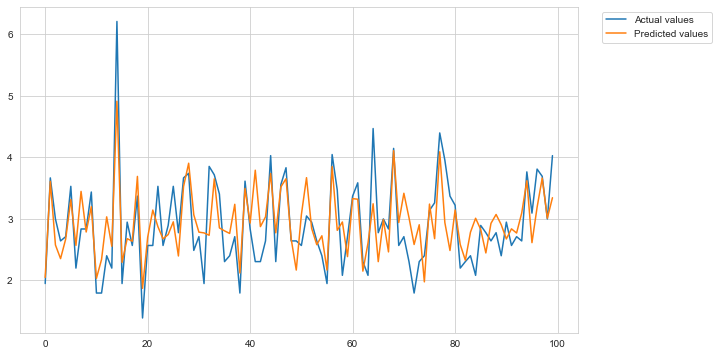

In [19]:
rfr_best = RandomForestRegressor(n_estimators=500)

display(Markdown("#### Execution Time - Training"))
%time rfr_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = rfr_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

___
### Second Approach
- Encode categorical features using OHE.

In [36]:
X_train.head()

,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2
1142652,2,missing,0,electronics,tv_audio_surveillance,headphones
1142448,2,lularoe,0,women,athletic_apparel,pants_tights_leggings
220982,2,missing,1,vintage_collectibles,antique,book
479456,1,missing,1,vintage_collectibles,collectibles,souvenir
1299063,3,victoria's_secret,0,women,underwear,bras


In [37]:
# ohe for brand_name

ohe_brand = OneHotEncoder(handle_unknown="ignore")
ohe_brand.fit(product_listings_mercari.brand_name.values.reshape(-1,1))

tr_brand_ohe = ohe_brand.transform(X_train.brand_name.values.reshape(-1,1))
val_brand_ohe = ohe_brand.transform(X_test.brand_name.values.reshape(-1,1))

tr_brand_ohe.shape, val_brand_ohe.shape

((1185328, 4802), (296333, 4802))

In [38]:
# ohe for category-related features

# main cat
ohe_mcat = OneHotEncoder(handle_unknown="ignore")
ohe_mcat.fit(product_listings_mercari.main_cat.values.reshape(-1,1))

tr_mcat_ohe = ohe_mcat.transform(X_train.main_cat.values.reshape(-1,1))
val_mcat_ohe = ohe_mcat.transform(X_test.main_cat.values.reshape(-1,1))

# sub cat1
ohe_scat1 = OneHotEncoder(handle_unknown="ignore")
ohe_scat1.fit(product_listings_mercari.sub_cat1.values.reshape(-1,1))

tr_scat1_ohe = ohe_scat1.transform(X_train.sub_cat1.values.reshape(-1,1))
val_scat1_ohe = ohe_scat1.transform(X_test.sub_cat1.values.reshape(-1,1))

# sub cat2
ohe_scat2 = OneHotEncoder(handle_unknown="ignore")
ohe_scat2.fit(product_listings_mercari.sub_cat2.values.reshape(-1,1))

tr_scat2_ohe = ohe_scat2.transform(X_train.sub_cat2.values.reshape(-1,1))
val_scat2_ohe = ohe_scat2.transform(X_test.sub_cat2.values.reshape(-1,1))

tr_mcat_ohe.shape, val_mcat_ohe.shape, tr_scat1_ohe.shape, val_scat1_ohe.shape, tr_scat2_ohe.shape, val_scat2_ohe.shape

((1185328, 11),
 (296333, 11),
 (1185328, 113),
 (296333, 113),
 (1185328, 870),
 (296333, 870))

In [39]:
# ohe for shipping and item_condition

# item comdition
ohe_cond = OneHotEncoder(handle_unknown="ignore")
ohe_cond.fit(product_listings_mercari.item_condition_id.values.reshape(-1,1))

tr_cond_ohe = ohe_cond.transform(X_train.brand_name.values.reshape(-1,1))
val_cond_ohe = ohe_cond.transform(X_test.brand_name.values.reshape(-1,1))

# shipping
ohe_ship = OneHotEncoder(handle_unknown="ignore")
ohe_ship.fit(product_listings_mercari.shipping.values.reshape(-1,1))

tr_ship_ohe = ohe_ship.transform(X_train.brand_name.values.reshape(-1,1))
val_ship_ohe = ohe_ship.transform(X_test.brand_name.values.reshape(-1,1))

tr_cond_ohe.shape, val_cond_ohe.shape, tr_ship_ohe.shape, val_ship_ohe.shape

((1185328, 5), (296333, 5), (1185328, 2), (296333, 2))

<u>Stacking all features</u>

In [40]:
x_train = hstack((tr_cond_ohe, tr_brand_ohe, tr_ship_ohe, tr_mcat_ohe, tr_scat1_ohe, tr_scat2_ohe))
x_train.shape

(1185328, 5803)

In [41]:
x_val = hstack((val_cond_ohe, val_brand_ohe, val_ship_ohe, val_mcat_ohe, val_scat1_ohe, val_scat2_ohe))
x_val.shape

(296333, 5803)

#### Ridge

In [40]:
'''Hyper-param tuning'''

ridge = Ridge()
ridge_params = {'alpha': list(np.logspace(-4, 0, 30))} # from 0.0001 to 1

grid_cv = GridSearchCV(ridge, param_grid=ridge_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

CPU times: user 41.3 s, sys: 14.6 s, total: 55.9 s
Wall time: 5min 15s


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.00013738237958832623,
                                   0.00018873918221350977,
                                   0.0002592943797404667, 0.0003562247890262444,
                                   0.0004893900918477494, 0.0006723357536499335,
                                   0.0009236708571873865, 0.0012689610031679222,
                                   0.0017433288221999873, 0.002395026619987486,
                                   0.0032903445623126675, 0.004520353656360241,
                                   0.006210169418915...172805,
                                   0.011721022975334805, 0.01610262027560939,
                                   0.02212216291070448, 0.03039195382313198,
                                   0.041753189365604, 0.05736152510448681,
                                   0.07880462815669913, 0.1082636733874054,
                                   0.14873521072935117, 0.20433597178569418,
                                   0.2807216203941176, 0.38566204211634725,
                                   0.5298316906283708, 0.7278953843983146,
                                   1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [41]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.592004 using {'alpha': 1.0}


In [42]:
# top 5 combination of params
df = pd.DataFrame(grid_cv.cv_results_)
df = df.sort_values('rank_test_score')[['param_alpha', 'params', 'mean_test_score','std_test_score','rank_test_score']]
df.iloc[:5,]

,param_alpha,params,mean_test_score,std_test_score,rank_test_score
29,1.0,{'alpha': 1.0},-0.592004,0.001112,1
28,0.727895,{'alpha': 0.7278953843983146},-0.592039,0.001109,2
27,0.529832,{'alpha': 0.5298316906283708},-0.592075,0.001101,3
26,0.385662,{'alpha': 0.38566204211634725},-0.592117,0.001097,4
25,0.280722,{'alpha': 0.2807216203941176},-0.592151,0.001099,5


#### Execution Time - Training

CPU times: user 42.2 s, sys: 15.6 s, total: 57.8 s
Wall time: 13.3 s


#### Execution Time - Prediction

CPU times: user 12.8 ms, sys: 5.76 ms, total: 18.6 ms
Wall time: 5.44 ms


#### Model in Test Data

R2: 0.3724
RMSLE: 0.5905


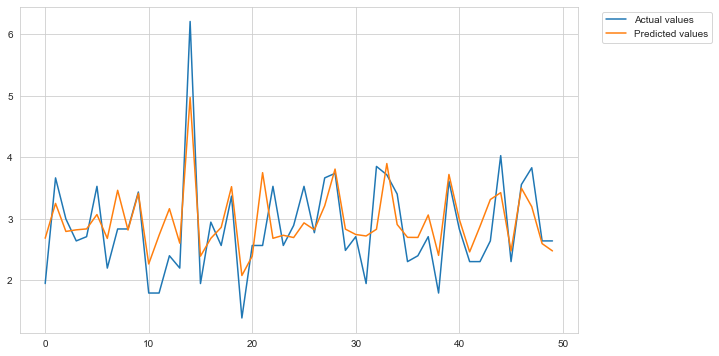

In [43]:
ridge_best = Ridge(alpha=1)
display(Markdown("#### Execution Time - Training"))
%time ridge_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = ridge_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### Lasso

In [42]:
'''Hyper-param tuning'''

lasso = Lasso()
lasso_params = {'alpha': [0.1, 1]}

grid_cv = GridSearchCV(lasso, param_grid=lasso_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True, cv=3)
%time grid_cv.fit(x_train, y_train)

CPU times: user 7.91 s, sys: 509 ms, total: 8.42 s
Wall time: 15.1 s


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1, param_grid={'alpha': [0.1, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [43]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.746041 using {'alpha': 0.1}


In [44]:
# top 5 combination of params
df = pd.DataFrame(grid_cv.cv_results_)
df = df.sort_values('rank_test_score')[['param_alpha', 'params', 'mean_test_score','std_test_score','rank_test_score']]
df.iloc[:5,]

,param_alpha,params,mean_test_score,std_test_score,rank_test_score
0,0.1,{'alpha': 0.1},-0.746041,0.001303,1
1,1,{'alpha': 1},-0.746041,0.001303,1


In [ ]:
'''lasso_best = Lasso(alpha=0.01)
display(Markdown("#### Execution Time - Training"))
%time lasso_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lasso_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])'''

#### Execution Time - Training

#### LightGBM

In [45]:
'''Hyper-param tuning'''

lgb = LGBMRegressor(random_state=42)
lgb_params = { "learning_rate": [0.1,0.3,1], 
              "max_depth": [3, 5, 7], 
              "n_estimators": [100, 150, 200],
              "reg_alpha": [0, 1, 1.5]
}

grid_cv = GridSearchCV(lgb, param_grid=lgb_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True, cv=3)
%time grid_cv.fit(x_train, y_train)

CPU times: user 15.5 s, sys: 3.24 s, total: 18.8 s
Wall time: 5min 57s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 150, 200],
                         'reg_alpha': [0, 1, 1.5]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [46]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.582347 using {'learning_rate': 1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1}


In [47]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

,params,mean_test_score,std_test_score,rank_test_score
79,"{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1}",-0.582347,0.001018,1
78,"{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0}",-0.582474,0.000905,2
80,"{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1.5}",-0.582605,0.001079,3
75,"{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0}",-0.583641,0.000969,4
76,"{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 1}",-0.583667,0.000982,5


#### Execution Time - Training

CPU times: user 14.5 s, sys: 2.45 s, total: 17 s
Wall time: 2.83 s


#### Execution Time - Prediction

CPU times: user 3.76 s, sys: 33.9 ms, total: 3.79 s
Wall time: 494 ms


#### Model in Test Data

R2: 0.3774
RMSLE: 0.5882


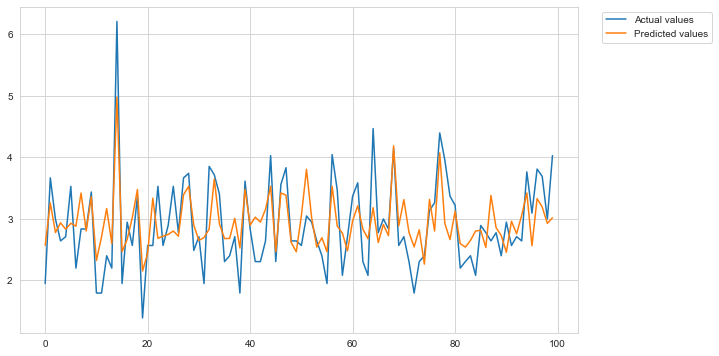

In [48]:
lgb_best = LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=7, n_estimators=200, reg_alpha=1.5)

display(Markdown("#### Execution Time - Training"))
%time lgb_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lgb_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### SGD
- https://scikit-learn.org/stable/modules/sgd.html#regression
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

In [ ]:
'''Hyper-param tuning'''
sgd = SGDRegressor(max_iter=4000, alpha=0.01)
sgd_params = grid_param = {'penalty': ['l2', 'l1'], 
                           'learning_rate': ['optimal', 'invscaling'], 
                          }

grid_cv = GridSearchCV(sgd, param_grid=sgd_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True, cv=3)
%time grid_cv.fit(x_train, y_train)

In [54]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.658614 using {'learning_rate': 'invscaling', 'penalty': 'l2'}


#### Execution Time - Training

CPU times: user 2.98 s, sys: 56.1 ms, total: 3.04 s
Wall time: 2.67 s


#### Execution Time - Prediction

CPU times: user 16.3 ms, sys: 912 µs, total: 17.2 ms
Wall time: 16.6 ms


#### Model in Test Data

R2: 0.3497
RMSLE: 0.6011


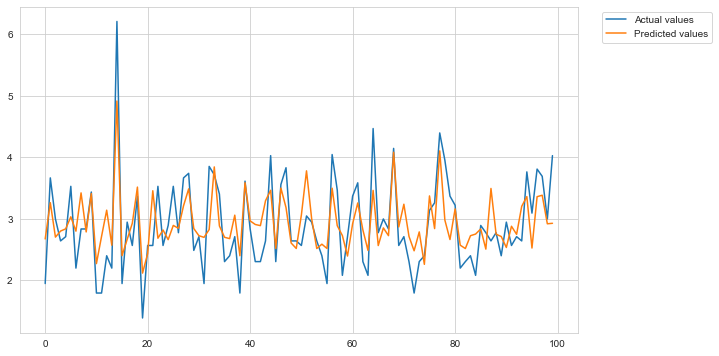

In [56]:
sgd = SGDRegressor()

display(Markdown("#### Execution Time - Training"))
%time sgd.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = sgd.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

In [ ]:
# top 5 combination of params
'''with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])'''

#### RandomForest

In [ ]:
'''Hyper-param tuning'''

rfr = RandomForestRegressor()
rfr_params = grid_param = {'n_estimators': [300, 500, 700]}

grid_cv = GridSearchCV(rfr, param_grid=rfr_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True) # cv=5 by default
%time grid_cv.fit(x_train, y_train)

In [ ]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

In [ ]:
# top 5 combination of params
with pd.option_context('display.max_colwidth', None):
    df = pd.DataFrame(grid_cv.cv_results_)
    df = df.sort_values('rank_test_score')[['params', 'mean_test_score','std_test_score','rank_test_score']]
    display(df.iloc[:5,])

In [ ]:
rfr_best = RandomForestRegressor(n_estimators=500)

display(Markdown("#### Execution Time - Training"))
%time rfr_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = rfr_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle)) 

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### Linear Regression

#### Execution Time - Training

CPU times: user 53.9 s, sys: 18.8 s, total: 1min 12s
Wall time: 15.7 s


#### Execution Time - Prediction

CPU times: user 5.04 ms, sys: 2.65 ms, total: 7.68 ms
Wall time: 1.93 ms


#### Model in Test Data

R2: 0.3719
RMSLE: 0.5908


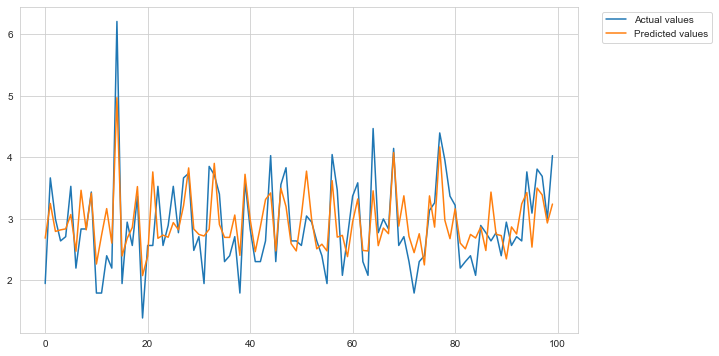

In [59]:
# linear Regression
lr = LinearRegression()

display(Markdown("#### Execution Time - Training"))
%time lr.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lr.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

___

Summary:

| **Model**         | **Notes**                                         | **RMSLE** |
|-------------------|---------------------------------------------------|-----------|
| Ridge             | No text features. Ordinal encode.                 | 0.7199    |
| Lasso             | No text features. Ordinal encode.                 | 0.7199    |
| LightGBM          | No text features. Ordinal encode.                 | 0.5587    |
| SGD               | No text features. Ordinal encode.                 | 0.72      |
| RandomForest      | No text features. Ordinal encode. 500 estimators. | 0.5521    |
| Ridge             | No text features. OHE.                            | 0.5905    |
| LightGBM          | No text features. OHE.                            | 0.5882    |
| SGD               | No text features. OHE.                            | 0.6011    |
| Linear Regression | No text features. OHE.                            | 0.5908    |